# NBA All Star Classification by Ryan and Nico

## Introduction
We are exploring the ability to use averages per game on different statistics to predict if a player will be an all-star or not in the NBA

A few things we want to explore are: how accurately we can predict all stars and non all stars, the effect that fan voting has on all star selections, the effect that a player's city size and team valuation have on their all star status, how all star selection has changed over the years, the best features to use to predict all stars, and the effect of the three point shot on all star selection.

### Note:
May have to run "pip install plotly" in order to see the plotly graphs

## All Star Background
Midway through the NBA season, the NBA hosts an all star game where the top talent in the league competes head-to-head in the same game. All star selection has been tweaked over the years since the first all star game in 1951. From 1951-1974, members of the media were responsible for selecting all 16 all stars (8 per team). In 1975, the NBA introduced fan voting. Fans would vote for the 10 all star starters (5 per team). Additionally, NBA coaches were responsible for voting on 14 bench players (7 per team).  In 2016, the protocol changed again. Now, to select all star starters, fans account for 50% of the vote, current players account for 25%, and the media accounts for 25%. NBA coaches still select the 14 bench players.
https://www.deseret.com/sports/2023/1/15/23539127/how-does-nba-all-star-selection-work

## Accuracy vs Recall
To judge our models and experiments, we will be using both accuracy and recall. As a reminder, acuracy is TP + TN / TP + TN + FP + FN. In our case, accuracy describes the total number of NBA players that are correctly classified as either an all star or not an all star. Because there are a very small number of all stars compared to non all stars, it is very easy for a model to accurately classify non all stars as non all stars. Where it gets tricky, however, is how well the model classifys known all stars. This is why recall is used to evaluate model effectiveness. Recall is TP / TP + FN. In other words, it tells what percentage of actual all stars are correctly classified as all stars.

## Datasets
We used one dataset from kaggle to get all the all stars from every year since 1951 and to get all players per game states since 1947: https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats

We also used another dataset for team valuation. https://www.kaggle.com/code/noahgift/nba-team-valuation-exploration/input?select=nba_2017_team_valuations.csv

## Importing required libraries

In [45]:
import pandas as pd
import numpy as np
import sklearn as sk
import plotly
import plotly.graph_objects as go
import seaborn as sn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Preparing data
allstar_selections_data contains all the all-star selections since 1951

player_per_game_data contains all player stats per game (ex: points per game [PPG]) since 1947

In [46]:
# Helper function to get the results for the all-stars
def is_all_star(name, year, allstar_df):
    temp_df = allstar_df.loc[(allstar_df["player"] == name) & (allstar_df["season"] == year)]
    if len(temp_df) == 0:
        return 0
    return 1

In [47]:
allstar_selections_data = pd.read_csv('All-Star Selections.csv')
allstar_selections_data = allstar_selections_data.drop_duplicates(subset=['player', 'season'])
player_per_game_data = pd.read_csv("Player Per Game.csv")
player_per_game_data = player_per_game_data.drop_duplicates()
player_per_game_data = player_per_game_data[player_per_game_data["season"] >= 1951]

tagged_player_per_game_data = player_per_game_data.copy()
tagged_player_per_game_data['is-all-star'] = tagged_player_per_game_data.apply(lambda x: is_all_star(x["player"], x["season"], allstar_selections_data), axis=1)
tagged_player_per_game_data = tagged_player_per_game_data.drop_duplicates(subset=['player', 'season'])
tagged_player_per_game_data = tagged_player_per_game_data.drop(columns=['seas_id', 'birth_year', 'player_id', 'gs'])
tagged_player_per_game_data = tagged_player_per_game_data.dropna()
print(len(tagged_player_per_game_data))

16043


In [48]:
allstar_selections_data

,player,team,lg,season,replaced
0,Bam Adebayo,Giannis,NBA,2023,False
1,Giannis Antetokounmpo,Giannis,NBA,2023,False
2,DeMar DeRozan,Giannis,NBA,2023,False
3,Kevin Durant,Giannis,NBA,2023,False
4,Shai Gilgeous-Alexander,Giannis,NBA,2023,False
...,...,...,...,...,...
1969,Alex Groza,West,NBA,1951,False
1970,George Mikan,West,NBA,1951,False
1971,Vern Mikkelsen,West,NBA,1951,False
1972,Jim Pollard,West,NBA,1951,False


In [49]:
tagged_player_per_game_data[tagged_player_per_game_data["is-all-star"] == 1]
# Note: had to drop a bunch of data due to NaN's being annoying

,season,player,pos,age,experience,lg,tm,g,mp_per_game,fg_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,is-all-star
25,2023,Anthony Edwards,SG,21.0,3,NBA,MIN,79,36.0,8.9,...,0.6,5.2,5.8,4.4,1.6,0.7,3.3,2.4,24.6,1
31,2023,Bam Adebayo,C,25.0,6,NBA,MIA,75,34.6,8.0,...,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,1
103,2023,Damian Lillard,PG,32.0,11,NBA,POR,58,36.3,9.6,...,0.8,4.0,4.8,7.3,0.9,0.3,3.3,1.9,32.2,1
127,2023,De'Aaron Fox,PG,25.0,6,NBA,SAC,73,33.4,9.3,...,0.5,3.6,4.2,6.1,1.1,0.3,2.5,2.4,25.0,1
135,2023,DeMar DeRozan,SF,33.0,14,NBA,CHI,74,36.2,8.9,...,0.5,4.2,4.6,5.1,1.1,0.5,2.1,2.5,24.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,1974,Willie Wise,SF,26.0,5,ABA,UTS,82,40.1,8.7,...,2.1,5.5,7.6,3.7,1.4,0.5,2.5,3.0,22.3,1
25496,1973,Artis Gilmore,C,23.0,2,ABA,KEN,84,41.7,8.2,...,5.3,12.2,17.6,3.5,0.9,3.1,3.4,3.6,20.8,1
25579,1973,Dan Issel,PF,24.0,3,ABA,KEN,84,42.0,10.7,...,3.9,7.1,11.0,2.6,1.1,0.5,2.6,3.0,27.3,1
25745,1973,Julius Erving,SF,22.0,2,ABA,VIR,71,42.2,12.6,...,3.7,8.5,12.2,4.2,2.5,1.8,4.6,2.8,31.9,1


## Visualizing the features

C:\Users\rjreg\AppData\Local\Temp\ipykernel_34140\133615257.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



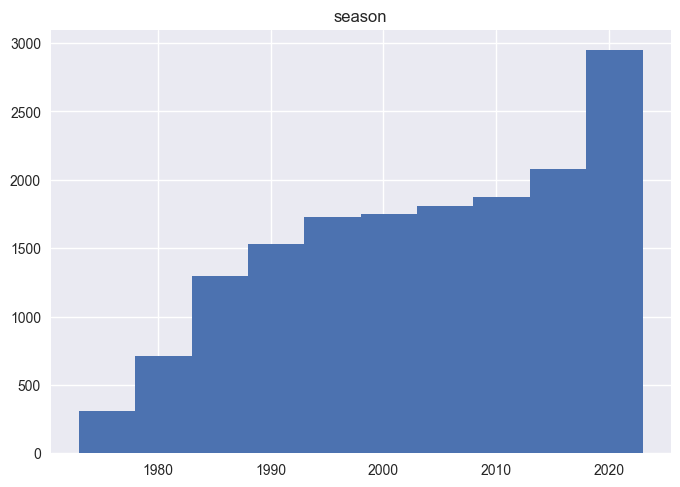

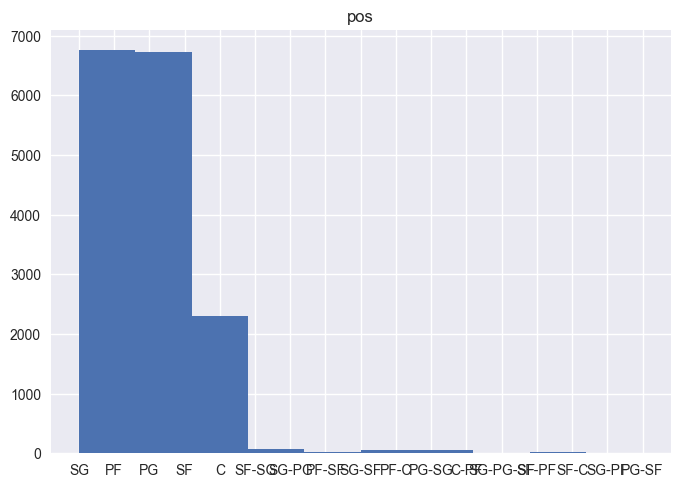

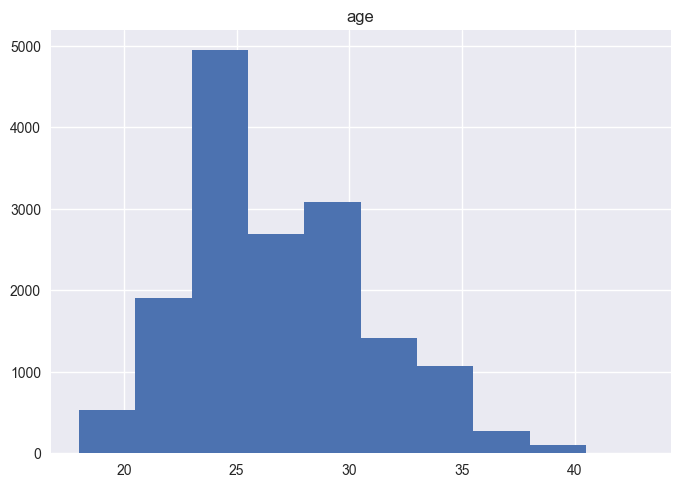

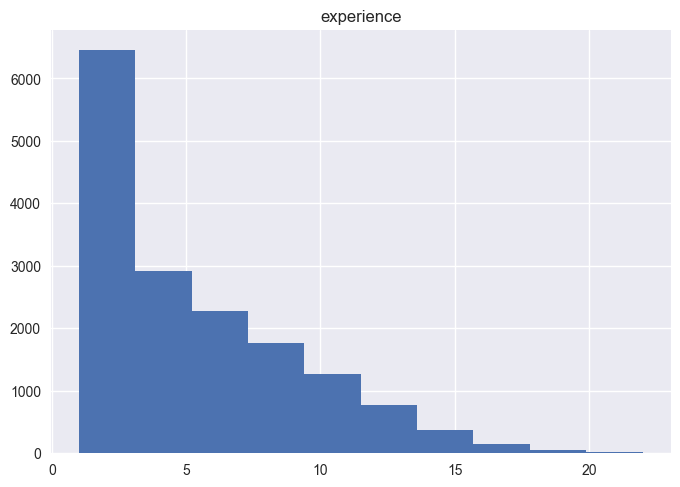

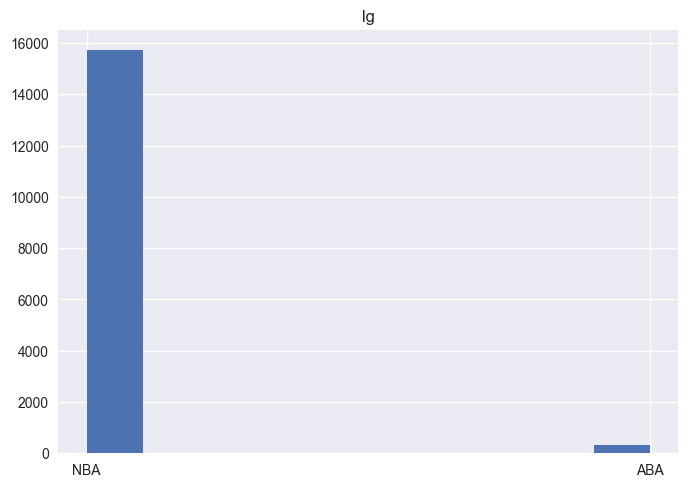

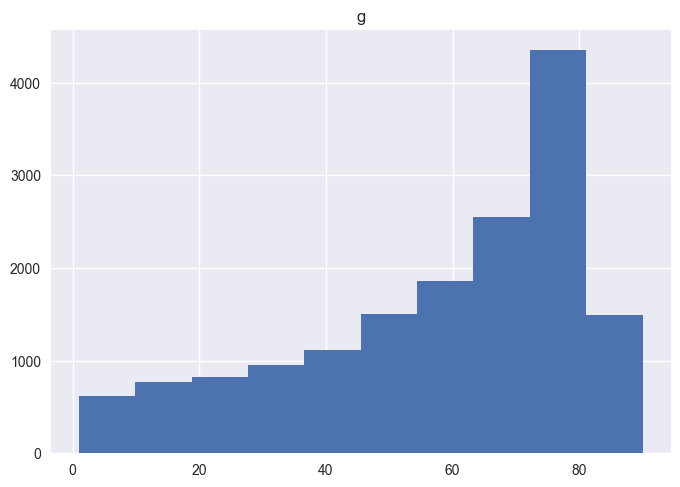

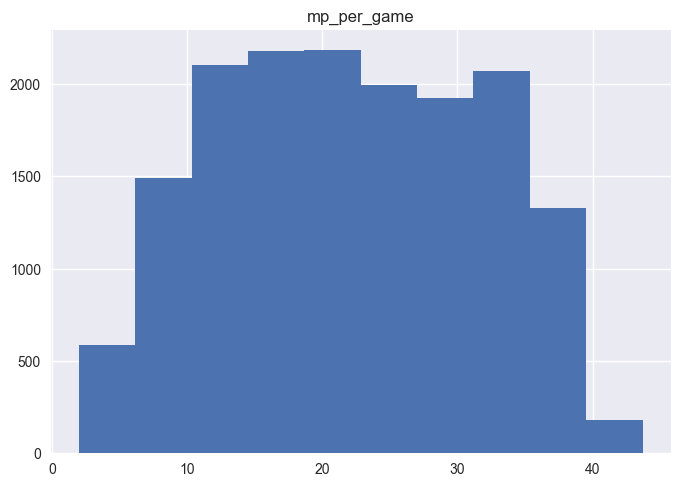

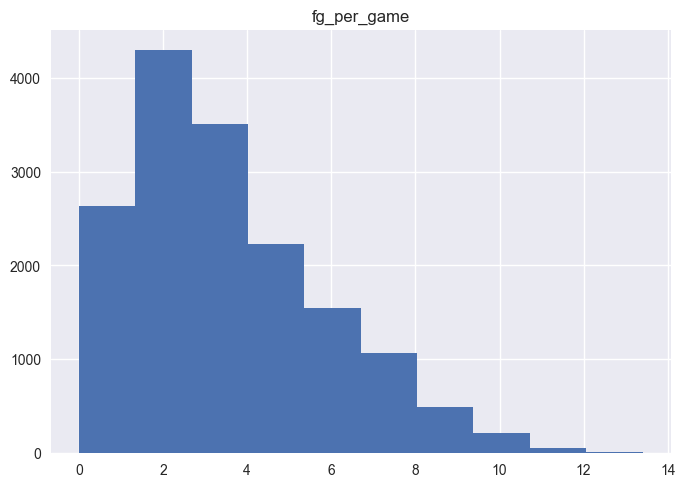

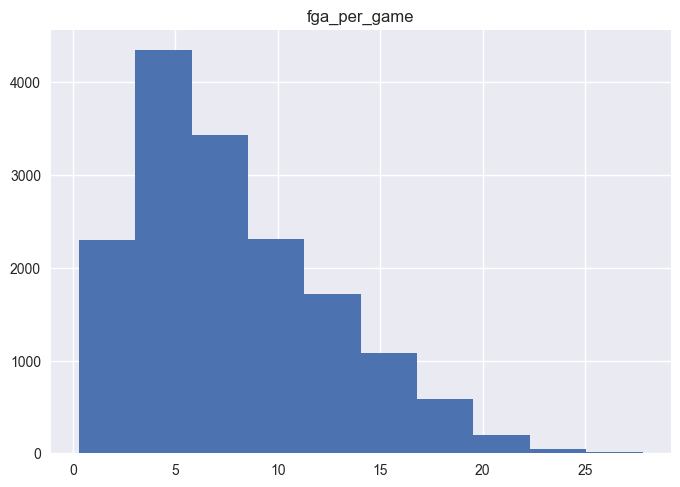

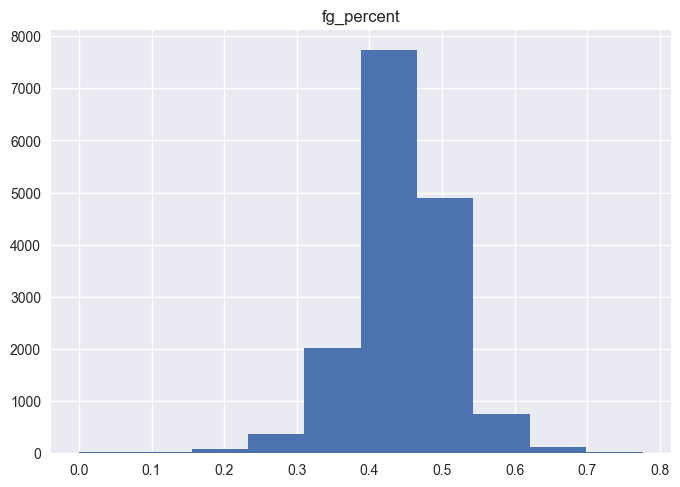

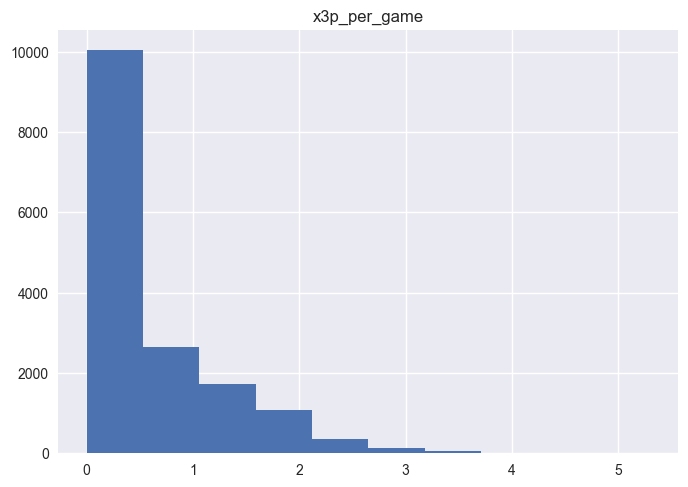

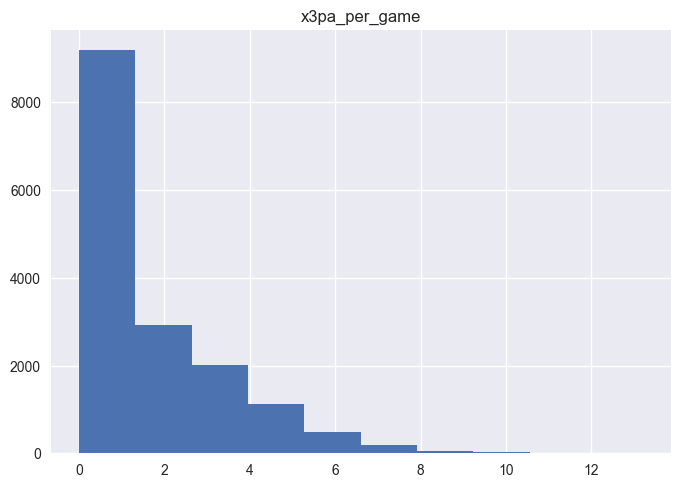

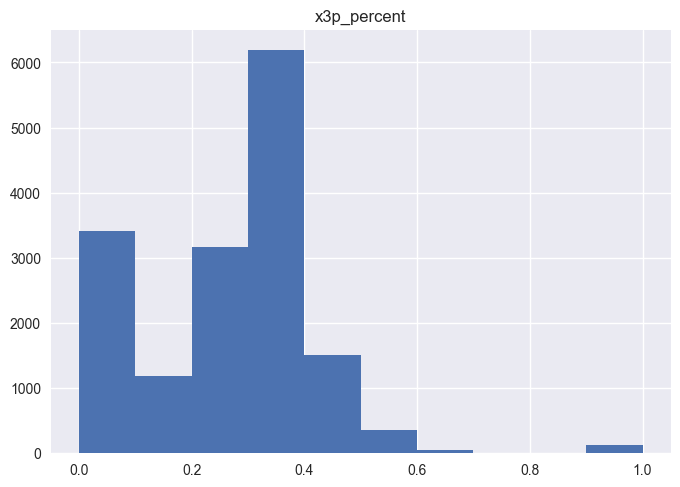

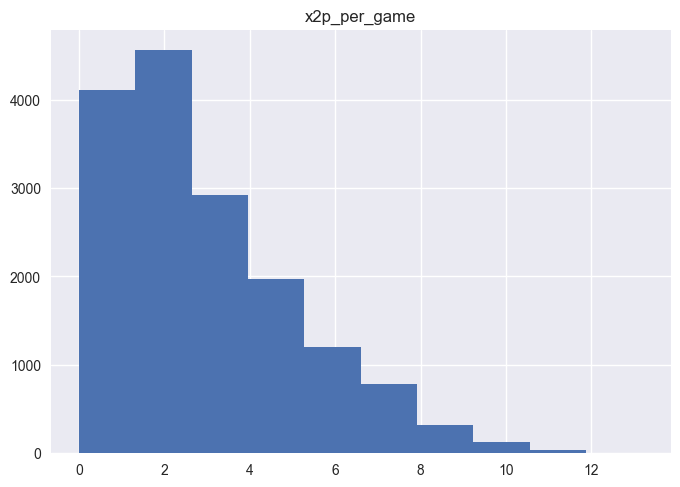

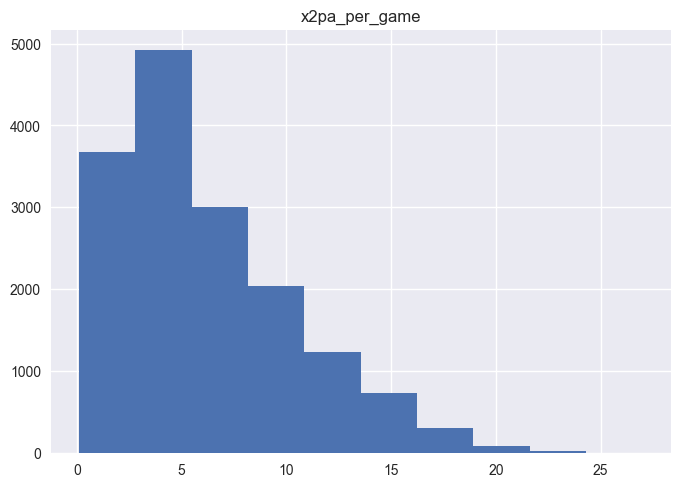

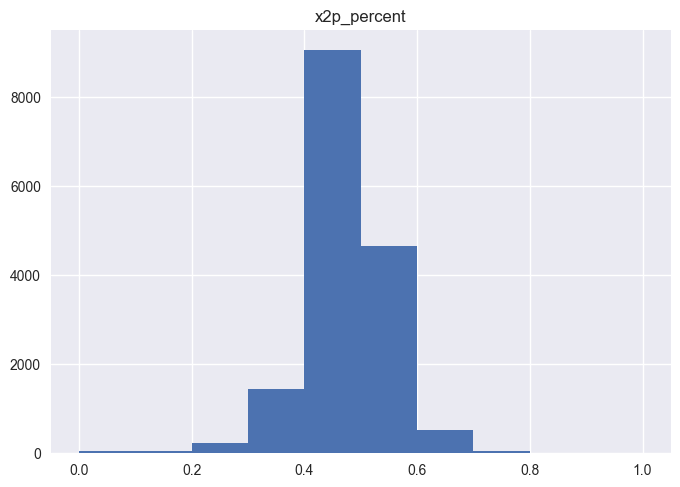

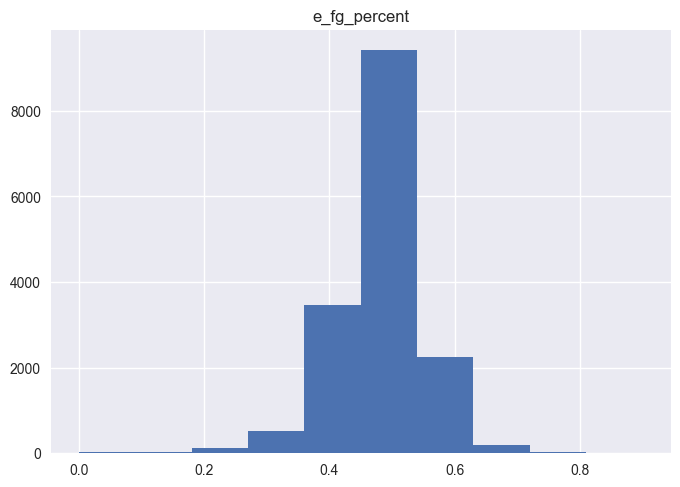

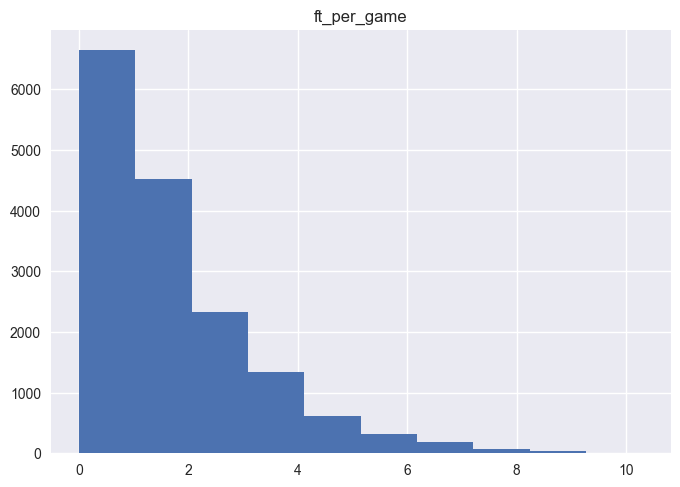

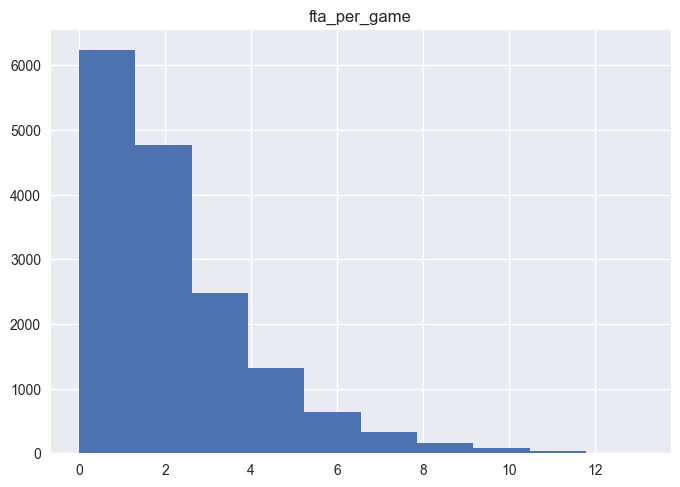

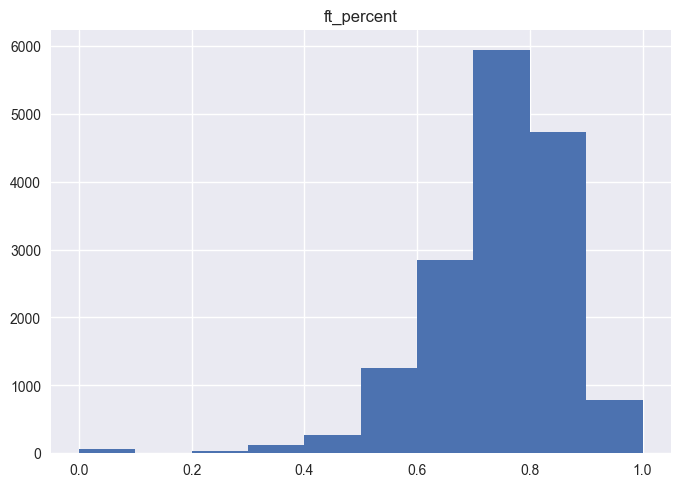

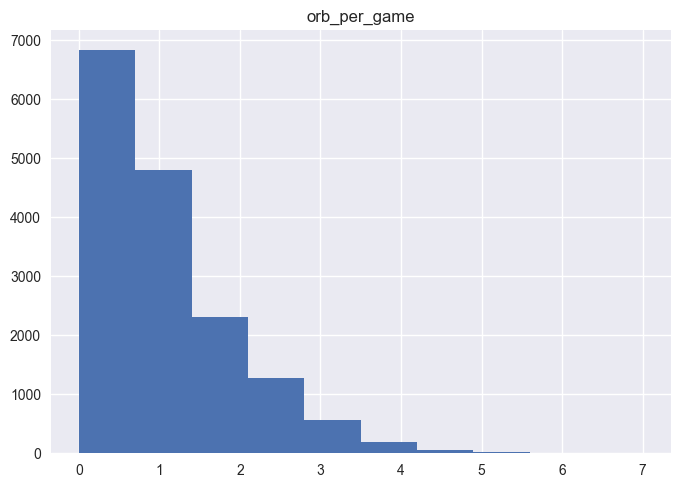

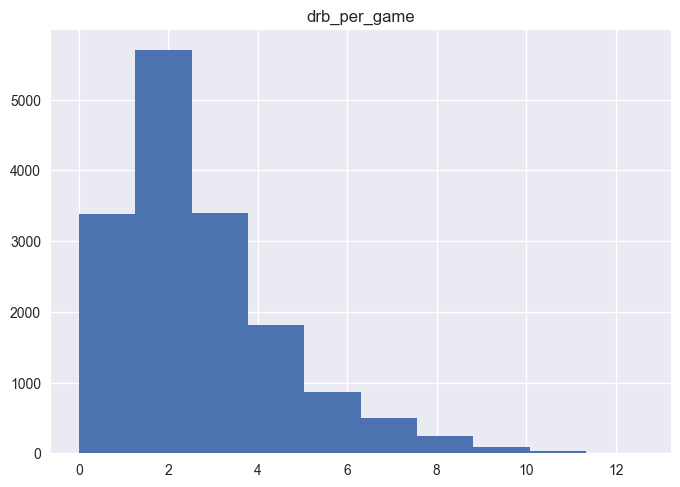

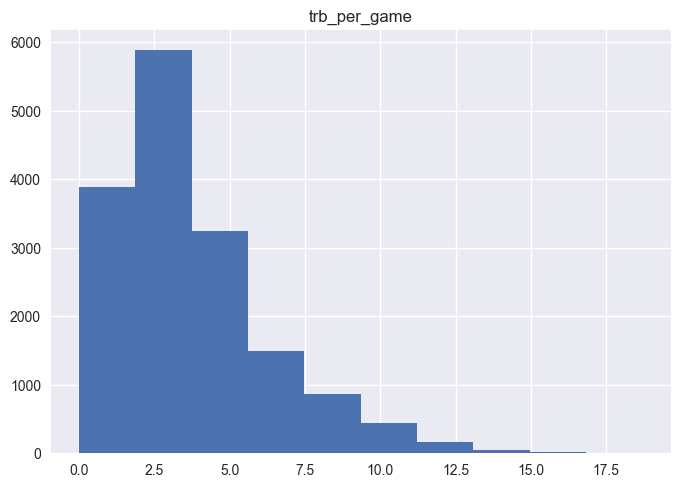

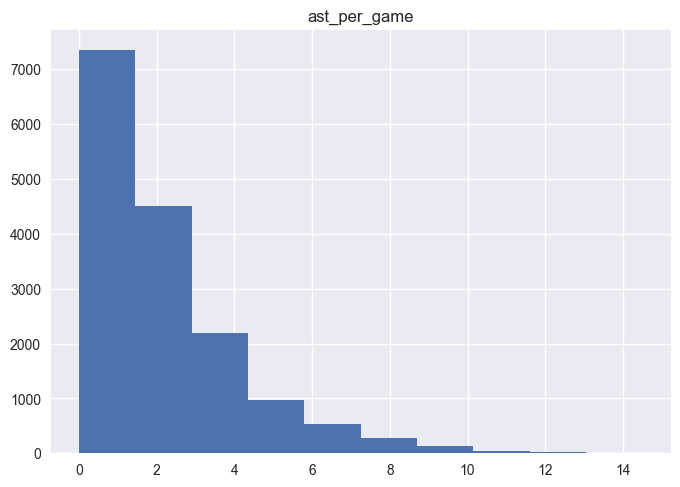

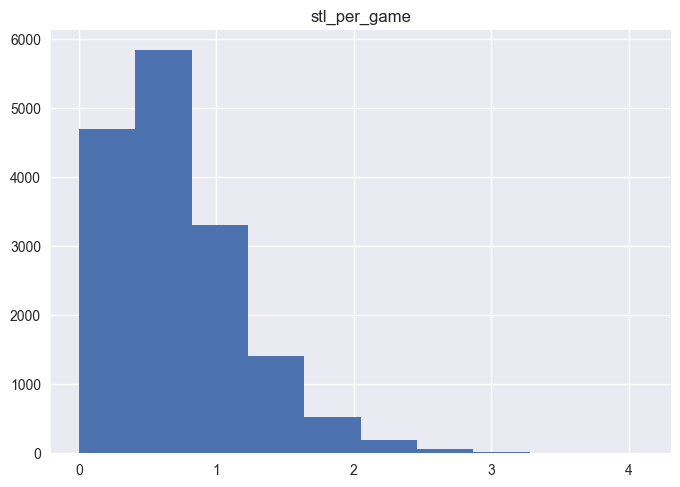

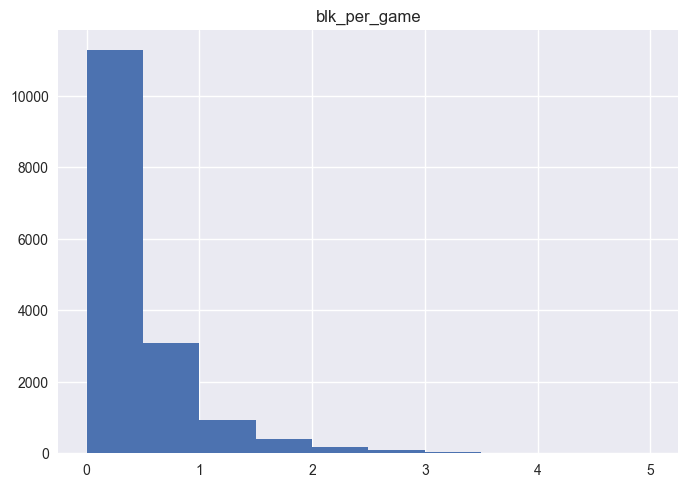

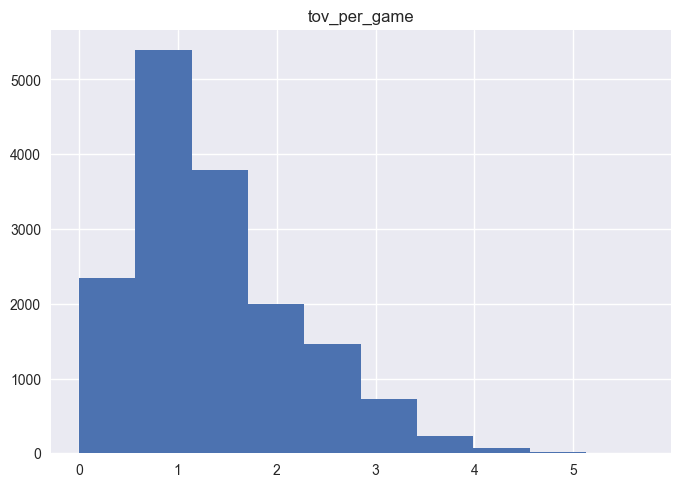

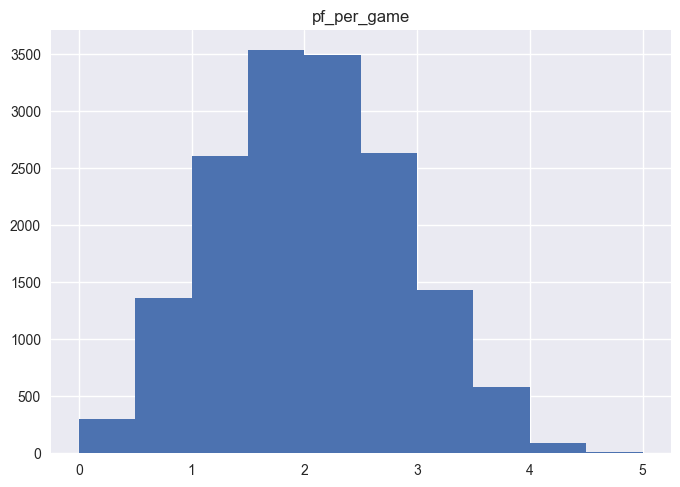

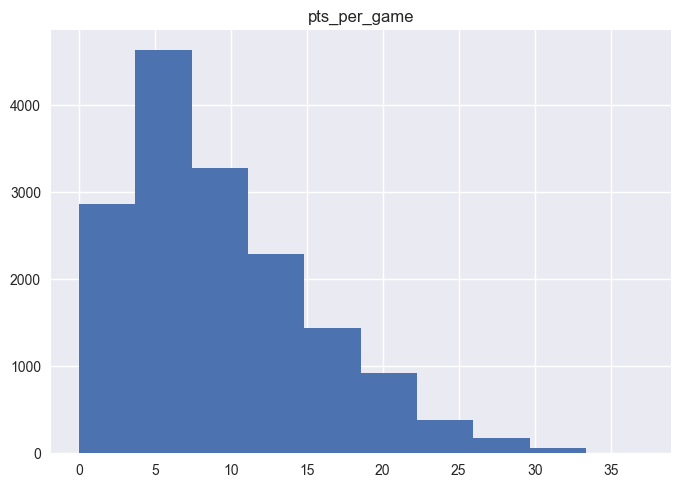

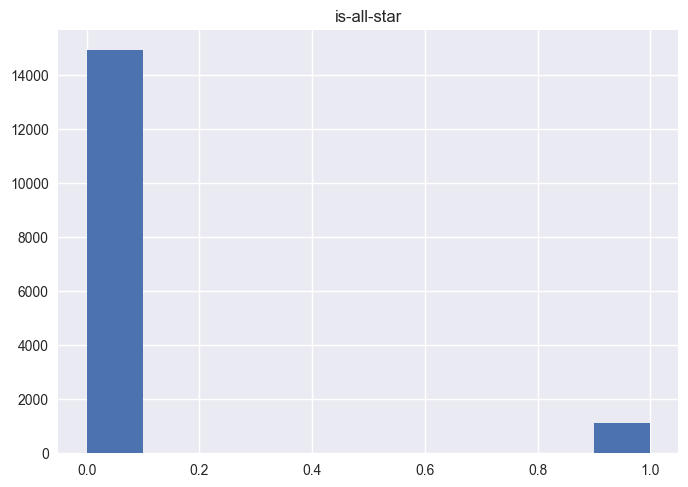

In [50]:
feature_graphs = tagged_player_per_game_data.copy()
feature_graphs = feature_graphs.drop(columns=['player', 'tm'])
for i in feature_graphs.columns:
    plt.figure()
    plt.title(i)
    plt.hist(feature_graphs[i])

## Helper function for generating training and testing data

In [51]:
def generate_train_test_data(years='all', testsize=0.2, randomstate=42):
    if years =='all':
        X = tagged_player_per_game_data.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
        y = tagged_player_per_game_data['is-all-star'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
    else:
        years_split = years.split('.')
        year_start = int(years_split[0])
        year_end = int(years_split[1])
        temp_df = tagged_player_per_game_data.copy()
        temp_df = temp_df.loc[(temp_df['season'] >= year_start) & (temp_df['season'] < year_end)]
        X = temp_df.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
        y = temp_df['is-all-star'].values
        if testsize == 0:
            return X, None, y, None
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
    return X_train, X_test, y_train, y_test

## Why this is an interesting problem?
Notice the outliers in the 3D plot. x=points per game, y=assists per game, z=rebounds per game.
There is a fair amount of clustering where points are high, but there are some outliers as all-stars like Draymond Green and Chris Paul who are playmakers/role players.
There are also some players who appear to have all-star stats who did not make it (Anthony Davis, Kyrie Irving, etc.).
This may be due to fan votes and other circumstances (Kyrie's antisemtic social media posts, Anthony Davis' injuries).
Potential Solution: use many more features such as steals, blocks, turnovers, ORD, DRD, fouls, etc. Or use better features.

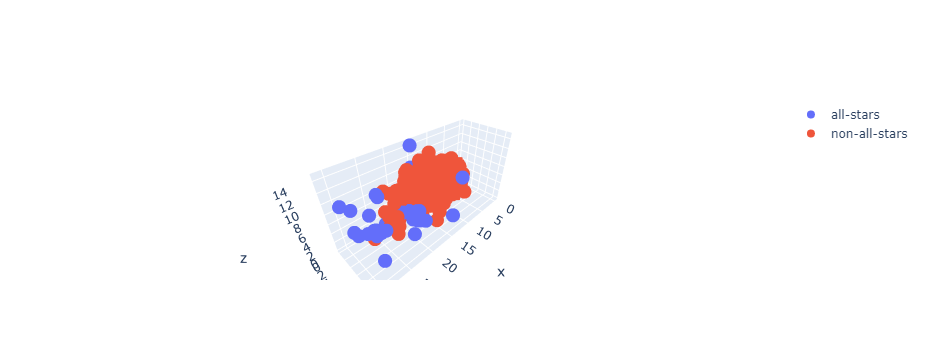

In [52]:
allstar_2022 = allstar_selections_data[allstar_selections_data["season"] == 2022]
allstar_2022_list = allstar_2022["player"].tolist()
allstar_2023 = allstar_selections_data[allstar_selections_data["season"] == 2023]
allstar_2023_list = allstar_2023["player"].tolist()
player_per_game_data = pd.read_csv("Player Per Game.csv")
allstar_2022_player_data = player_per_game_data[player_per_game_data["season"] == 2022]
not_allstar_2022_player_data = allstar_2022_player_data.loc[~allstar_2022_player_data["player"].isin(allstar_2022_list)]
allstar_2022_player_data = allstar_2022_player_data.loc[allstar_2022_player_data["player"].isin(allstar_2022_list)]
allstar_2023_player_data = player_per_game_data[player_per_game_data["season"] == 2023]
not_allstar_2023_player_data = allstar_2023_player_data.loc[~allstar_2023_player_data["player"].isin(allstar_2023_list)]
allstar_2023_player_data = allstar_2023_player_data.loc[allstar_2023_player_data["player"].isin(allstar_2023_list)]
allstar_2023_player_data = allstar_2023_player_data[["season", "player", "pos", "pts_per_game", "ast_per_game", "trb_per_game"]]
allstar_2022_player_data = allstar_2022_player_data[["season", "player", "pos", "pts_per_game", "ast_per_game", "trb_per_game"]]
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=allstar_2022_player_data['pts_per_game'], y=allstar_2022_player_data['ast_per_game'], z=allstar_2022_player_data['trb_per_game'],
                                   mode='markers', text=allstar_2022_player_data['player'], name='all-stars'))
fig.add_trace(go.Scatter3d(x=not_allstar_2022_player_data['pts_per_game'], y=not_allstar_2022_player_data['ast_per_game'], z=not_allstar_2022_player_data['trb_per_game'],
                                   mode='markers', text=not_allstar_2022_player_data['player'], name='non-all-stars'))
fig.show()

## KNN Classifier test with all data
First, we will train a K-Nearest-Neighbors model on data from 1951-2023 and test it on a subset of this data.

In [53]:
# for n in range(1,10):
#     X_train, X_test, y_train, y_test = generate_train_test_data()
#     knn = KNeighborsClassifier(n_neighbors = n)
#     knn.fit(X_train,y_train)
#     print("Number of neighbors: ", n)
#     print("Train data results:", knn.score(X_train, y_train))
#     print("Test data results:", knn.score(X_test, y_test))
#     print()
# 3 typically yielded the best results
X_train, X_test, y_train, y_test = generate_train_test_data()
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Number of neighbors: ", 3)
print("Train data accuracy:", knn.score(X_train, y_train))
print("Test data accuracy:", knn.score(X_test, y_test))
y_pred = knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))

Number of neighbors:  3
Train data accuracy: 0.9732741156303568
Test data accuracy: 0.9504518541601745
Test Accuracy: 0.9504518541601745
Test Precision: 0.7083333333333334
Test Recall: 0.5690376569037657


## KNN Classifier before fans voted (1951 to 1974)
Fan voting for all stars was introduced in 1974. Here, we will look at how well we can train a model on what should be "less subjective" all stars. Observe the problem of overfitting here. This is in part because of a much smaller sample size.

In [54]:
X_train, X_test, y_train, y_test = generate_train_test_data("1951.1974")
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Number of neighbors: ", 3)
print("Train data results:", knn.score(X_train, y_train))
print("Test data results:", knn.score(X_test, y_test))
y_pred = knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))

Number of neighbors:  3
Train data results: 1.0
Test data results: 0.6666666666666666
Test Accuracy: 0.6666666666666666
Test Precision: 1.0
Test Recall: 0.5


## KNN Classifier after fans voted (1974 to Present)
Here, we look at how well a model performs on data from after fan voting was introduced. Theoretically, you might expect subjective fan voting to be volatile and therefore the model will not perform well. However, this is not the case in our experiment. Accuracy has increased but likely due to an increase in data and more correct non-allstars classified.

In [55]:
X_train, X_test, y_train, y_test = generate_train_test_data("1974.2023")
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Number of neighbors: ", 3)
print("Train data results:", knn.score(X_train, y_train))
print("Test data results:", knn.score(X_test, y_test))
y_pred = knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))

Number of neighbors:  3
Train data results: 0.971909207984546
Test data results: 0.9571796522858983
Test Accuracy: 0.9571796522858983
Test Precision: 0.757396449704142
Test Recall: 0.5818181818181818


## Applying PCA
Here, we applied PCA to our model so that it would not have to deal with so many features.

Results without PCA:

- Train data accuracy: 0.9732741156303568
- Test data accuracy: 0.9504518541601745
- Test Accuracy: 0.9504518541601745
- Test Precision: 0.7083333333333334
- Test Recall: 0.5690376569037657

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_train, X_test, y_train, y_test = generate_train_test_data()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(.95) # 0.95 means it will choose n amount of components to retain 95% of the variance
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Number of PCA components:", pca.n_components_)
print("Number of neighbors: ", 3)
print("Train data results:", knn.score(X_train, y_train))
print("Test data results:", knn.score(X_test, y_test))
y_pred = knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))

Number of PCA components: 11
Number of neighbors:  3
Train data results: 0.974520804114072
Test data results: 0.9492053599252104
Test Accuracy: 0.9492053599252104
Test Precision: 0.69
Test Recall: 0.5774058577405857


### Recall has increased but accuracy has decreased

## How well do certain years predict other years?
Here, we repeatedly trained a knn model on data from one year and used it to predict every other individual year. We were curious to see if years would better predict other chronologically close years. Perhaps over the years what is been valued in an all star has changed.

Note: we only use three features (pts per game, ast per game, and reb per game) for simplicity sake and because these are some of the only stats that have always been tracked in the nba.

In [57]:
all_stars = pd.read_csv('All-Star Selections.csv')
statistics = pd.read_csv("Player Per Game.csv")
statistics.drop_duplicates(inplace=True, subset=["player", "season"])
def knn_classify(number_of_neighbors, training_year, test_year, feature_1, feature_2, feature_3):
    training_year_all_stars = (all_stars[all_stars["season"] == training_year]["player"]).tolist()
    test_year_all_stars = (all_stars[all_stars["season"] == test_year]["player"]).tolist()

    tagged_training_year_statistics = statistics[statistics["season"] == training_year][["season", "player", feature_1, feature_2, feature_3]].dropna()
    tagged_training_year_statistics['all_star'] = tagged_training_year_statistics['player'].apply(lambda x: 1 if x in training_year_all_stars else 0)
    tagged_test_year_statistics = statistics[statistics["season"] == test_year][["season", "player", feature_1, feature_2, feature_3]].dropna()
    tagged_test_year_statistics['all_star'] = tagged_test_year_statistics['player'].apply(lambda x: 1 if x in test_year_all_stars else 0)
    
    X_train = list(zip(tagged_training_year_statistics[feature_1], tagged_training_year_statistics[feature_2], tagged_training_year_statistics[feature_3]))
    y_train = tagged_training_year_statistics['all_star']
    
    X_test = list(zip(tagged_test_year_statistics[feature_1], tagged_test_year_statistics[feature_2], tagged_test_year_statistics[feature_3]))
    y_test = tagged_test_year_statistics['all_star']
    
    knn = KNeighborsClassifier(n_neighbors=number_of_neighbors)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    return (accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, zero_division=0))

In [58]:
accuracies = []
recalls = []
for i in range(1951, 2024):
    year_accuracies = []
    year_recalls = []
    for j in range(1951, 2024):
        result = knn_classify(5, i, j, "pts_per_game", "ast_per_game", "trb_per_game")
        year_accuracies.append(result[0])
        year_recalls.append(result[1])
    accuracies.append(year_accuracies)
    recalls.append(year_recalls)

C:\Users\rjreg\AppData\Local\Temp\ipykernel_34140\2766120404.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



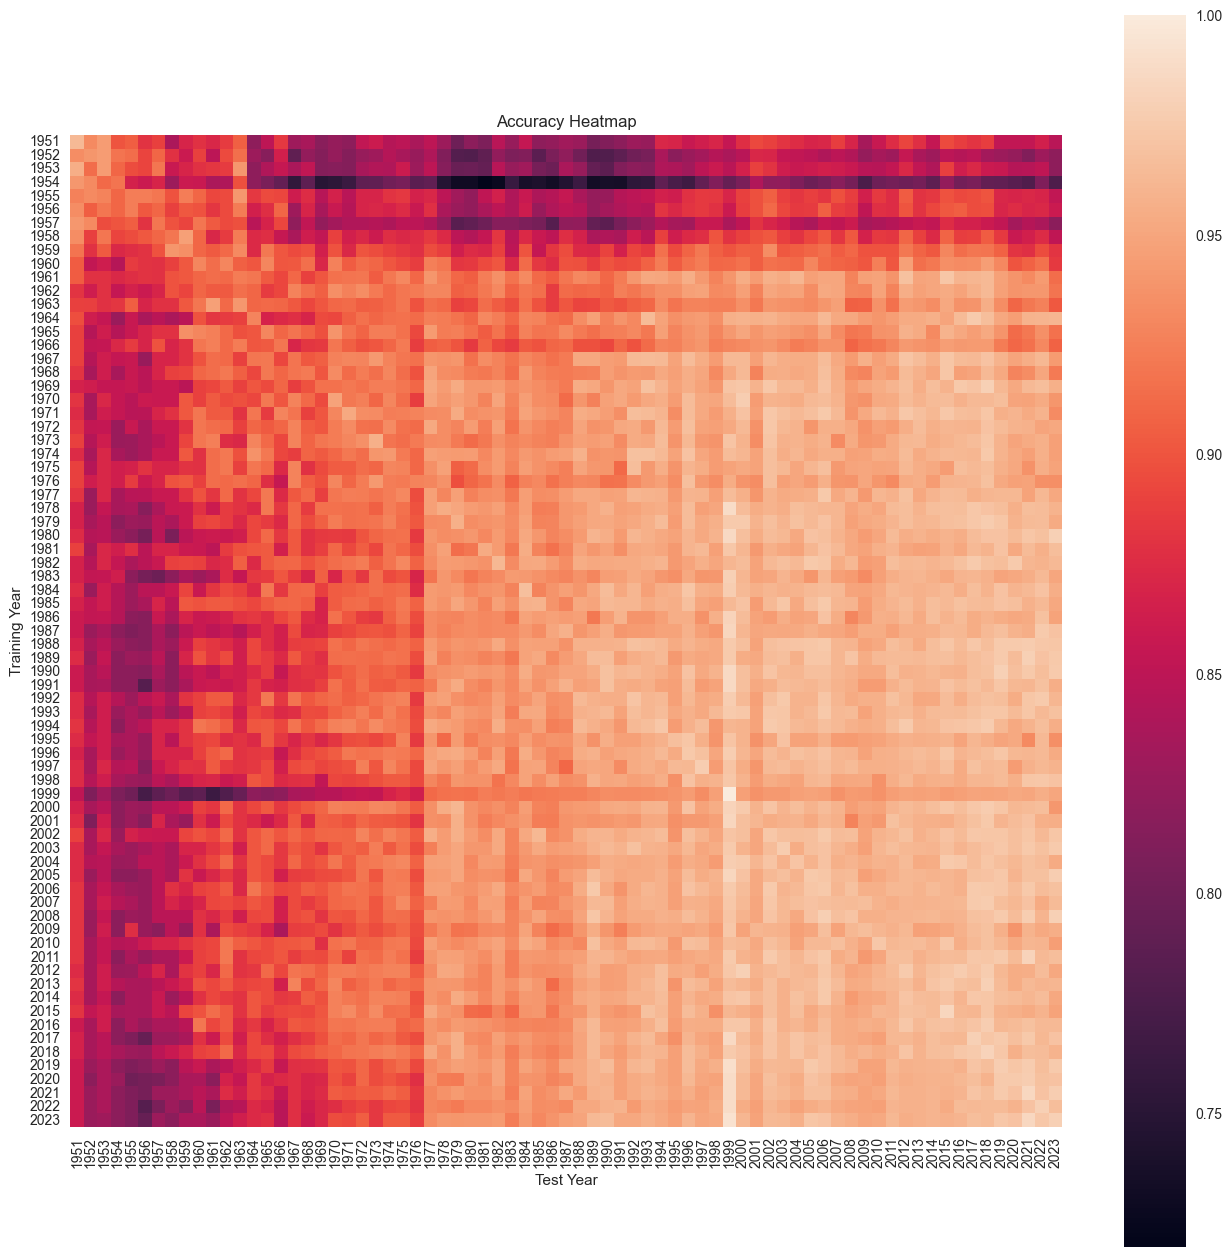

In [59]:
plt.style.use("seaborn")
plt.figure(figsize=(16,16))
plt.title( "Accuracy Heatmap" )

hm = sn.heatmap(data = accuracies, square = True, xticklabels = range(1951, 2024), yticklabels = range(1951, 2024))

hm.set(xlabel = "Test Year", ylabel = "Training Year")
  
plt.show()

C:\Users\rjreg\AppData\Local\Temp\ipykernel_34140\1351238701.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



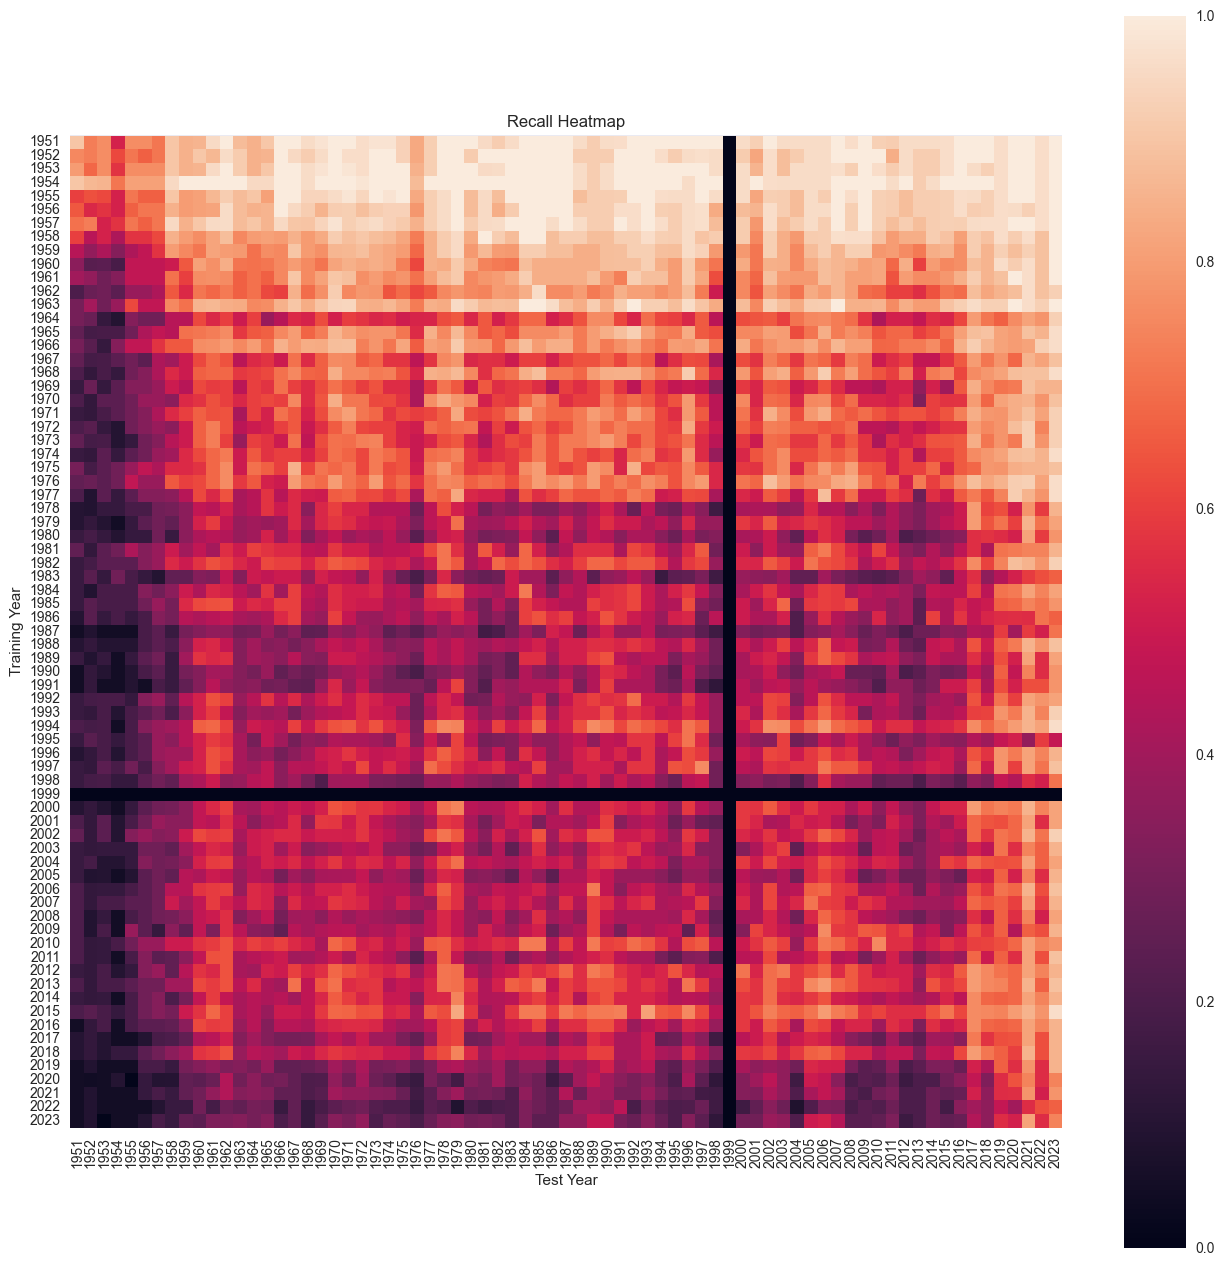

In [60]:
plt.style.use("seaborn")
plt.figure(figsize=(16,16))
plt.title( "Recall Heatmap" )

hm = sn.heatmap(data = recalls, square = True, xticklabels = range(1951, 2024), yticklabels = range(1951, 2024))

hm.set(xlabel = "Test Year", ylabel = "Training Year")
  
plt.show()

## What features are the best to use? Has this changed historically?
Here we look at what combination of 3 features out of the 25 provided in our dataset are the most useful in training a model. Also, we look at this for each decade. We hope to see if certain statistics are valued more or less across decades.

In [61]:
def knn_classify_year_range(number_of_neighbors, years, feature_1, feature_2, feature_3):
    years_split = years.split('.')
    year_start = int(years_split[0])
    year_end = int(years_split[1])
    temp_df = tagged_player_per_game_data.copy()
    temp_df = temp_df.loc[(temp_df['season'] >= year_start) & (temp_df['season'] < year_end)]
    #X = temp_df.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
    X = temp_df[[feature_1, feature_2, feature_3]]
    y = temp_df['is-all-star'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    knn = KNeighborsClassifier(n_neighbors=number_of_neighbors)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    return (accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, zero_division=0))

In [62]:
def find_three_best_features(years):
    features = ['experience', 'g', 'mp_per_game' ,'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game']
    results = []

    for i in range(len(features)):
        for j in range(len(features)):
            for k in range(len(features)):
                if i != j and i != k and j != k:
                    result = knn_classify_year_range(5, years, features[i], features[j], features[k])
                    results.append((features[i], features[j], features[k], result[0], result[1]))

    max_accuracy = results[0]
    max_recall = results[0]

    for i in range(len(results)):
        if results[i][3] > max_accuracy[3]:
            max_accuracy = results[i]
        if results[i][4] > max_recall[4]:
            max_recall = results[i]

    print("Max accuracy: ", max_accuracy[:3], max_accuracy[3])
    print("Max recall: ", max_recall[:3], max_recall[4])

## 1970s

In [63]:
find_three_best_features('1970.1980')

Max accuracy:  ('experience', 'fg_per_game', 'drb_per_game') 0.9354838709677419
Max recall:  ('fg_per_game', 'ft_percent', 'stl_per_game') 0.875


## 1980s

In [64]:
find_three_best_features('1980.1990')

Max accuracy:  ('experience', 'tov_per_game', 'pts_per_game') 0.9533980582524272
Max recall:  ('fg_per_game', 'stl_per_game', 'tov_per_game') 0.6458333333333334


## 1990s

In [65]:
find_three_best_features('1990.2000')

Max accuracy:  ('g', 'fta_per_game', 'pts_per_game') 0.9542097488921714
Max recall:  ('g', 'fta_per_game', 'pts_per_game') 0.5434782608695652


## 2000s

In [66]:
find_three_best_features('2000.2010')

Max accuracy:  ('fg_per_game', 'orb_per_game', 'pts_per_game') 0.9626038781163435
Max recall:  ('fg_percent', 'x2p_per_game', 'orb_per_game') 0.6666666666666666


## 2010s

In [67]:
find_three_best_features('2010.2020')

Max accuracy:  ('fta_per_game', 'ast_per_game', 'pts_per_game') 0.963985594237695
Max recall:  ('fta_per_game', 'ast_per_game', 'pts_per_game') 0.6551724137931034


## How well would it have done this year?
Here, we train the model on data from 1973 to 2022 and test it on this year's all stars.

In [68]:
X_train, X_test, y_train, y_test = generate_train_test_data('1973.2023', 0)
# Training model with all the test data minus 2023 (what we will predict)
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Train data results:", knn.score(X_train, y_train))
tagged_data_2023 = tagged_player_per_game_data[tagged_player_per_game_data["season"] == 2023]
playernames_2023 = tagged_data_2023['player'].tolist()
X = tagged_data_2023.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
y = tagged_data_2023['is-all-star'].values
predictions_2023 = knn.predict(X).tolist()
print("2023 accuracy:", knn.score(X, y))
print("2023 recall:", recall_score(y, predictions_2023))

Train data results: 0.9727173283572486
2023 accuracy: 0.9561752988047809
2023 recall: 0.7407407407407407


### Diving deeper into 2023 and who was actually selected and who was not

In [69]:
actual_2023_allstars_names = allstar_selections_data[allstar_selections_data["season"] == 2023]["player"].tolist()
all_stars_predicted = [(playernames_2023[i]) for i in range(len(predictions_2023)) if predictions_2023[i] == 1]
print(all_stars_predicted)

['Anthony Davis', 'Bojan Bogdanović', 'Bradley Beal', 'Brandon Ingram', 'Damian Lillard', 'Darius Garland', "De'Aaron Fox", 'DeMar DeRozan', 'Devin Booker', 'Donovan Mitchell', 'Fred VanVleet', 'Giannis Antetokounmpo', 'Jalen Brunson', 'James Harden', 'Jaylen Brown', 'Jayson Tatum', 'Joel Embiid', 'Jrue Holiday', 'Julius Randle', 'Kawhi Leonard', 'Kevin Durant', 'Klay Thompson', 'Kyle Kuzma', 'Kyrie Irving', 'Lauri Markkanen', 'LeBron James', 'Luka Dončić', 'Nikola Jokić', 'Pascal Siakam', 'Paul George', 'Russell Westbrook', 'Shai Gilgeous-Alexander', 'Stephen Curry', 'Trae Young', 'Zach LaVine']


In [70]:
print("Number of actual all-stars selected:", len(actual_2023_allstars_names), " Number model selected:", len(all_stars_predicted))

Number of actual all-stars selected: 27  Number model selected: 35


### Taking the intersection of our model and the actual results

In [71]:
intersection_lists = list(set(all_stars_predicted) & set(actual_2023_allstars_names))
print(intersection_lists)
print(len(intersection_lists))

['Kevin Durant', 'Shai Gilgeous-Alexander', 'Giannis Antetokounmpo', 'Paul George', 'Donovan Mitchell', 'Nikola Jokić', 'Damian Lillard', 'Kyrie Irving', "De'Aaron Fox", 'Jayson Tatum', 'Lauri Markkanen', 'Pascal Siakam', 'LeBron James', 'Luka Dončić', 'DeMar DeRozan', 'Joel Embiid', 'Jrue Holiday', 'Julius Randle', 'Jaylen Brown', 'Stephen Curry']
20


### Looking at the differences between our model and the actual results

In [72]:
falsely_predicted = [i for i in all_stars_predicted if i not in actual_2023_allstars_names]
print(falsely_predicted)
print(len(falsely_predicted))

['Anthony Davis', 'Bojan Bogdanović', 'Bradley Beal', 'Brandon Ingram', 'Darius Garland', 'Devin Booker', 'Fred VanVleet', 'Jalen Brunson', 'James Harden', 'Kawhi Leonard', 'Klay Thompson', 'Kyle Kuzma', 'Russell Westbrook', 'Trae Young', 'Zach LaVine']
15


In [73]:
not_predicted = [i for i in actual_2023_allstars_names if i not in all_stars_predicted]
print(not_predicted)
print(len(not_predicted))

['Bam Adebayo', 'Ja Morant', 'Domantas Sabonis', 'Anthony Edwards', 'Tyrese Haliburton', 'Jaren Jackson Jr.', 'Zion Williamson']
7


In [74]:
# Sanity check
total_misclassified = len(falsely_predicted + not_predicted)
total_data_points = len(y)
accuracy = 1 - (total_misclassified / total_data_points)
print("Total Accuracy", accuracy, knn.score(X, y))

Total Accuracy 0.9561752988047809 0.9561752988047809


## How has the evolution in the game in regards to the 3 point line affect classification?
The 3 point line was introduced in the NBA in 1979. Originally, it was not utilized very much. However, in recent years the NBA game has undergone a revolution whereby the 3 pointer is one of the primary means of scoring. Here, we look at if that revolution has any affect on prediciting all stars. We train our model on the four decades since the 3 was introduced and on three statistics relating to 3 pointers: 3 pts attempted, 3 pts made, and 3 pt percentage. The results do indicate that a heavier and heavier emphasis is being placed on the 3 over time as recall steadily increases each decade.

## 1980s

In [75]:
print("Accuracy:", knn_classify_year_range(6, '1980.1990', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[0])
print("Recall:", knn_classify_year_range(6, '1980.1990', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[1])

Accuracy: 0.9048543689320389
Recall: 0.0


## 1990s

In [76]:
print("Accuracy:", knn_classify_year_range(6, '1990.2000', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[0])
print("Recall:", knn_classify_year_range(6, '1990.2000', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[1])

Accuracy: 0.9276218611521418
Recall: 0.0


## 2000s

In [77]:
print("Accuracy:", knn_classify_year_range(6, '2000.2010', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[0])
print("Recall:", knn_classify_year_range(6, '2000.2010', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[1])

Accuracy: 0.9182825484764543
Recall: 0.03508771929824561


## 2010s

In [78]:
print("Accuracy:", knn_classify_year_range(6, '2010.2020', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[0])
print("Recall:", knn_classify_year_range(6, '2010.2020', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent')[1])

Accuracy: 0.9339735894357744
Recall: 0.10344827586206896


## Population and franchise analysis
Here, we look at the potential effect that the population of the city that a player plays in the value of the team that a player plays on could have on their all star selection. Theoretically, because of fan voting, you might expect that all stars would be more likely to come from bigger cities and more valuable (ie more fans) teams. However, we did not find much of a correlation. 

Note: Population data is from 2019 so we look at the 2019 all-stars (fan voting had long been in existence since 1974-1975 season)
Note: Franchise valuation data is from 2017 so we look at that year in a vacuum (valuations in USD millions)

In [79]:
from urllib.request import urlopen
import json
url = "https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json"
response = urlopen(url)
data_json = json.loads(response.read())
conversion_dict = dict([(data_json[i]['abbreviation'], data_json[i]['teamName']) for i in range(len(data_json))])
df_valuation = pd.read_csv("nba_2017_team_valuations.csv")
valuation_dict = df_valuation.set_index("TEAM").T.to_dict('records')[0]

pd.options.mode.chained_assignment = None  # default='warn'
df_city = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")
df_city = df_city[["City", "State", "Population"]]
abbr_to_city = {"ATL": "Atlanta", "BKN": "Brooklyn", "BOS": "Boston", "CHA": "Charlotte", "CHI": "Chicago", "CLE": "Cleveland", "DAL": "Dallas", "DEN": "Denver", "DET": "Detroit",
                "GSW": "San Francisco", "HOU": "Houston", "IND": "Indianapolis", "LAC": "Los Angeles", "LAL": "Los Angeles", "MEM": "Memphis", "MIA": "Miami", "MIL": "Milwuakee", "MIN": "Minneapolis",
                "NOP": "New Orleans", "NYK": "New York", "OKC": "Oklahoma City", "ORL": "Orlando", "PHI": "Philadelphia", "PHX": "Phoenix", "POR": "Portland", "SAC": "Sacramento",
                "SAS": "San Antonio", "TOR": "Toronto", "UTA": "Salt Lake City", "WAS": "Washington"}
cities = df_city["City"].tolist()
population = df_city["Population"].tolist()
city_dict = dict(zip(cities, population))
city_dict['Toronto'] = 3060000
city_dict['Milwuakee'] = 590952
df_players_city_analysis = tagged_player_per_game_data[tagged_player_per_game_data["is-all-star"] == 1]
df_players_city_analysis["city"] = df_players_city_analysis["tm"].apply(lambda x: abbr_to_city.get(x))
df_players_city_analysis = df_players_city_analysis.replace(to_replace='None', value=np.nan).dropna()
df_players_city_analysis["population"] = df_players_city_analysis["city"].apply(lambda x: city_dict.get(x))
df_players_city_analysis["team_valuation_2017"] = df_players_city_analysis["tm"].apply(lambda x: valuation_dict[conversion_dict[x]])
df_players_city_analysis.reset_index(inplace=True)
df_players_city_analysis = df_players_city_analysis[["season", "player", "tm", "city", "population", "team_valuation_2017", "is-all-star"]]
df_players_city_analysis

,season,player,tm,city,population,team_valuation_2017,is-all-star
0,2023,Anthony Edwards,MIN,Minneapolis,400070,770.0,1
1,2023,Bam Adebayo,MIA,Miami,417650,1350.0,1
2,2023,Damian Lillard,POR,Portland,66318,1050.0,1
3,2023,De'Aaron Fox,SAC,Sacramento,479686,1075.0,1
4,2023,DeMar DeRozan,CHI,Chicago,2718782,2500.0,1
...,...,...,...,...,...,...,...
894,1980,Magic Johnson,LAL,Los Angeles,3884307,3000.0,1
895,1980,Marques Johnson,MIL,Milwuakee,590952,785.0,1
896,1980,Micheal Ray Richardson,NYK,New York,8405837,3300.0,1
897,1980,Moses Malone,HOU,Houston,2195914,1650.0,1


### Population graph for 2019 all-stars
-No strong correlation between population and all-star selection for 2019

In [80]:
df_players_city_analysis_2019 = df_players_city_analysis[df_players_city_analysis["season"] == 2019]
df_players_city_analysis_2019

,season,player,tm,city,population,team_valuation_2017,is-all-star
91,2019,Anthony Davis,NOP,New Orleans,378715,750.0,1
92,2019,Ben Simmons,PHI,Philadelphia,1553165,800.0,1
93,2019,Blake Griffin,DET,Detroit,688701,900.0,1
94,2019,Bradley Beal,WAS,Washington,646449,1000.0,1
95,2019,Damian Lillard,POR,Portland,66318,1050.0,1
96,2019,Dirk Nowitzki,DAL,Dallas,1257676,1450.0,1
97,2019,Dwyane Wade,MIA,Miami,417650,1350.0,1
98,2019,Giannis Antetokounmpo,MIL,Milwuakee,590952,785.0,1
99,2019,James Harden,HOU,Houston,2195914,1650.0,1
100,2019,Joel Embiid,PHI,Philadelphia,1553165,800.0,1


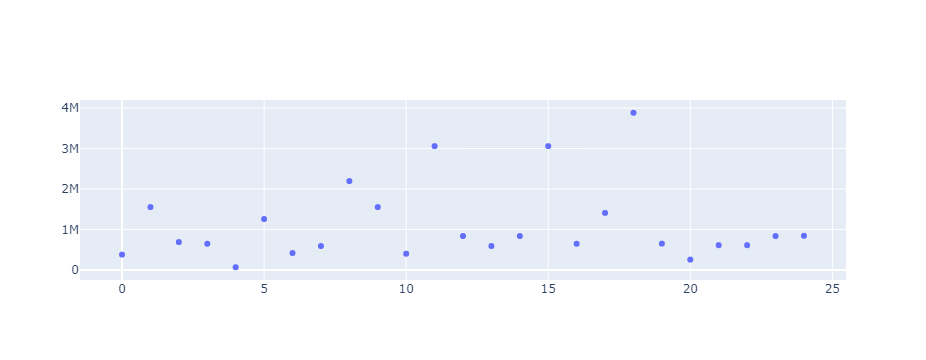

In [81]:
population_fig = go.Figure(data=go.Scatter(y=df_players_city_analysis_2019["population"], mode='markers'))
population_fig.show()

### Valuation graph for 2017 all-stars

In [82]:
df_players_val_analysis_2017 = df_players_city_analysis[df_players_city_analysis["season"] == 2017]
df_players_val_analysis_2017

,season,player,tm,city,population,team_valuation_2017,is-all-star
143,2017,Anthony Davis,NOP,New Orleans,378715,750.0,1
144,2017,Carmelo Anthony,NYK,New York,8405837,3300.0,1
145,2017,DeAndre Jordan,LAC,Los Angeles,3884307,2000.0,1
146,2017,DeMar DeRozan,TOR,Toronto,3060000,1125.0,1
147,2017,Draymond Green,GSW,San Francisco,837442,2600.0,1
148,2017,Giannis Antetokounmpo,MIL,Milwuakee,590952,785.0,1
149,2017,Gordon Hayward,UTA,Salt Lake City,191180,910.0,1
150,2017,Isaiah Thomas,BOS,Boston,645966,2200.0,1
151,2017,James Harden,HOU,Houston,2195914,1650.0,1
152,2017,Jimmy Butler,CHI,Chicago,2718782,2500.0,1


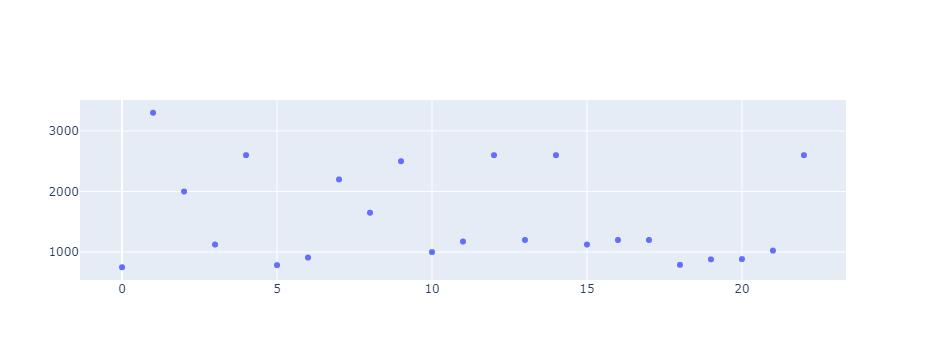

In [83]:
valuation_fig = go.Figure(data=go.Scatter(y=df_players_val_analysis_2017["team_valuation_2017"], mode='markers'))
valuation_fig.show()

- Team valuation is a much better potential indicator of all-star selection than population
- The majority of players selected in 2017 were on a team with a valuation greater than 1 billion USD

## Conclusions
- it is much easier to correctly classify non all stars than all stars
- despite our theory, all star selections after fans were introduced in 1974 is more predictable than before 1974
- In terms of accuracy, training our model on individual years before around 1960 did not produce a relatively accurate model tested on pretty much any year
- similarly, training a model on any individual year and testing it on any year before 1975 will not produce a relatively accurate model
- training and testing models on any year after 1970 produces a relatively accurate model in general
- in terms of recall, training and testing models on years before 1960 will not produce a good model
- otherwise, there are no clear patterns in terms of the effect of training and testing on individual years in terms of recall
- the best features to use to train a model vary from decade to decade, some features that were common in different decades were pts per game, fg per game, and ft attempted per game
- our model trained on all previous years and tested on this year does very well, with 96% accuracy and 74% recall
- false positives in the 2023 test set were very understandable as they are well known players with good stats, many of whom were considered all star snubs
- false negatives in the 2023 test set were also understandable as they were more fringe all stars and less well known
- the 3 pt line has become a better and better feature to use in predicting all stars over the years as the 3 pt shot has been embraced.
- city population and team valuation do not seem to have any noticeable affect on all star selection

## Limitations
- stats are for total season, all stars are selected midway through the season
- our statistics do not account for intangible features of players like popularity, injuries, social media presence, highlights, and personality
- all star voting is not formulaic; very subjective parties are responsible for selecting all stars, especially fans
- if a player was traded it caused a duplicate in the dataset
- some older data was hard to use for PCA due to NaN values for certain features (less comprehensive stat taking in the 1950s)